Cambiar el archivo SentenceTransformer.py en sentence-transformer e instalar con pip install -e sentence-transforme

In [1]:
from sentence_transformers import SentenceTransformer, models
from torch import nn
from sentence_transformers import LoggingHandler, SentenceTransformer, util, InputExample
import torch
from torch.utils.data import DataLoader
from sentence_transformers import evaluation
import pandas as pd
from sentence_transformers import models, losses
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import os
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

In [2]:
torch.cuda.device_count()

1

## Modelo

Siguiendo el esquema de entrenamiento para NLI de [este paper](https://arxiv.org/pdf/1908.10084.pdf).

Dimensiones a *ojímetro*.

In [3]:
word_embedding_model = models.Transformer('PlanTL-GOB-ES/roberta-base-bne')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(),
                           out_features=512, #ojimetro
                           activation_function=nn.Tanh())

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream tas

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/497k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [4]:
model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model], cache_folder='beto_sentemb')
model.cuda()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [5]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

## Dataset

In [6]:
esxnli = pd.read_table('esxnli.tsv')
label2int = {"contradiction": 0, "entailment": 1, "neutral": 2}
es_only_data = esxnli[esxnli.language == 'es']
es_only_data[['language', 'sentence1', 'sentence2', 'gold_label', 'promptID', 'pairID', 'genre', 'label1']]

#train_examples = [InputExample(texts=['Mi primera oración', 'Mi segunda oración'], label=0.8),
#   InputExample(texts=['Otro par', 'Oración cualquiera'], label=0.3)]
#train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

,language,sentence1,sentence2,gold_label,promptID,pairID,genre,label1
0,es,A ver si nos tenemos que poner todos en huelga...,La huelga es el método de lucha más eficaz par...,neutral,1,1,newspaper,neutral
1,es,A ver si nos tenemos que poner todos en huelga...,Tendremos que optar por hacer una huelga para ...,entailment,1,2,newspaper,entailment
2,es,A ver si nos tenemos que poner todos en huelga...,Queda descartada la huelga aunque no cobremos ...,contradiction,1,3,newspaper,contradiction
3,es,Profesor de FP y funcionario de carrera de la ...,Se dedica a la política y a la educación.,entailment,2,4,newspaper,entailment
4,es,Profesor de FP y funcionario de carrera de la ...,Gana mucho dinero.,neutral,2,5,newspaper,neutral
...,...,...,...,...,...,...,...,...
2485,es,Fue este verano cuando Cynthia decidió separar...,Cynthia ha mantenido una relación sentimental ...,entailment,829,2486,celebrity,entailment
2486,es,Fue este verano cuando Cynthia decidió separar...,Cynthia no tiene ningún abogado que la represe...,contradiction,829,2487,celebrity,contradiction
2487,es,"Eva Mendes, que firmó a sus fans imágenes de l...",Al-Fayed y Eva Mendes son los propietarios de ...,neutral,830,2488,celebrity,neutral
2488,es,"Eva Mendes, que firmó a sus fans imágenes de l...",Al-Fayed firmó a Eva Mendes imágenes de la cam...,contradiction,830,2489,celebrity,contradiction


Datos de entrenamiento en NLI

In [7]:
train_examples = []
for label, s1, s2 in es_only_data[['gold_label', 'sentence1', 'sentence2']].values:
    input_example = InputExample(texts=[s1, s2], label=label2int[label])
    train_examples.append(input_example)
    
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=64, drop_last=False)

Datos de testing en STS

In [8]:
sts_root = 'sts2015-es'
sts_files = [('STS.gs.newswire.txt', 'STS.input.newswire.txt'),
             ('STS.gs.wikipedia.txt', 'STS.input.wikipedia.txt')]

dev_examples = []
for gs_fname, sents_fname in sts_files:
    gs = open(os.path.join(sts_root, gs_fname))
    sents = open(os.path.join(sts_root, sents_fname))
    for g, s in zip(gs, sents):
        sent1, sent2 = s.split('\t')
        dp = InputExample(texts=[sent1, sent2], label=float(g))
        dev_examples.append(dp)
gs.close()
sents.close()
    
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_examples, batch_size=32,
                                                             name='dev-sts')

## Callback 

In [9]:
class Printable:
    def __init__(self, skip: int = 1) -> None:
        """
        Params
        ------
        skip: int, optional
          skip every skip epochs. Default: 1
        """
        self.skip = skip
  
    def __call__(self, score, epoch, steps) -> None:
        if epoch % self.skip == 0:
            print('--- Evaluation report ---')
            print('Epoch {}: {}'.format(epoch, score))
            
callback = Printable(skip=5)

In [10]:
train_loss = losses.SoftmaxLoss(model=model,
                                sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
                                num_labels=len(label2int))

In [11]:
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=20,
          warmup_steps=100, evaluator=evaluator, evaluation_steps=500,
          output_path='roberta_model', show_progress_bar=True, callback=callback)

/users/mmazuecos/miniconda3/envs/rud/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

--- Evaluation report ---
Epoch 0: 0.513780290096207
--- Evaluation report ---
Epoch 0: 0.5137838694668423
--- Evaluation report ---
Epoch 0: 0.5137381614719833
--- Evaluation report ---
Epoch 0: 0.5138087935874404
--- Evaluation report ---
Epoch 0: 0.5137387401912168
--- Evaluation report ---
Epoch 0: 0.5138083816757433
--- Evaluation report ---
Epoch 0: 0.5137635969315638
--- Evaluation report ---
Epoch 0: 0.5138550165601451
--- Evaluation report ---
Epoch 0: 0.5136801886257772
--- Evaluation report ---
Epoch 0: 0.5136026957003349
--- Evaluation report ---
Epoch 0: 0.5137302002130901
--- Evaluation report ---
Epoch 0: 0.5137843629626423
--- Evaluation report ---
Epoch 0: 0.5136744677626053
--- Evaluation report ---
Epoch 0: 0.51369414373548
--- Evaluation report ---
Epoch 0: 0.5135779101524166
--- Evaluation report ---
Epoch 0: 0.513675433799068
--- Evaluation report ---
Epoch 0: 0.5136553069410277
--- Evaluation report ---
Epoch 0: 0.513323920340204
--- Evaluation report ---
Epoch 0

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

--- Evaluation report ---
Epoch 5: 0.24281228686762354
--- Evaluation report ---
Epoch 5: 0.24760246480951892
--- Evaluation report ---
Epoch 5: 0.2535103296320791
--- Evaluation report ---
Epoch 5: 0.2636322073591433
--- Evaluation report ---
Epoch 5: 0.26725059594952716
--- Evaluation report ---
Epoch 5: 0.264512988198524
--- Evaluation report ---
Epoch 5: 0.2564600577032776
--- Evaluation report ---
Epoch 5: 0.24315628995017408
--- Evaluation report ---
Epoch 5: 0.22712433159969594
--- Evaluation report ---
Epoch 5: 0.2196810162124222
--- Evaluation report ---
Epoch 5: 0.2158075406506718
--- Evaluation report ---
Epoch 5: 0.21328972329974236
--- Evaluation report ---
Epoch 5: 0.21187371292335888
--- Evaluation report ---
Epoch 5: 0.2032163943375387
--- Evaluation report ---
Epoch 5: 0.19711155050061743
--- Evaluation report ---
Epoch 5: 0.19580191276906742
--- Evaluation report ---
Epoch 5: 0.1952301509256804
--- Evaluation report ---
Epoch 5: 0.1951447005542933
--- Evaluation repor

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

--- Evaluation report ---
Epoch 10: 0.1805350448864693
--- Evaluation report ---
Epoch 10: 0.18130607256432935
--- Evaluation report ---
Epoch 10: 0.18354055148300646
--- Evaluation report ---
Epoch 10: 0.187226479387876
--- Evaluation report ---
Epoch 10: 0.18569159697722748
--- Evaluation report ---
Epoch 10: 0.18544092740371693
--- Evaluation report ---
Epoch 10: 0.18468833632526854
--- Evaluation report ---
Epoch 10: 0.18486993256831774
--- Evaluation report ---
Epoch 10: 0.18630342788605384
--- Evaluation report ---
Epoch 10: 0.1874095954430493
--- Evaluation report ---
Epoch 10: 0.18908689987396018
--- Evaluation report ---
Epoch 10: 0.1909110011114345
--- Evaluation report ---
Epoch 10: 0.19357094220174215
--- Evaluation report ---
Epoch 10: 0.19608674260574058
--- Evaluation report ---
Epoch 10: 0.19856166432475694
--- Evaluation report ---
Epoch 10: 0.20032677696642495
--- Evaluation report ---
Epoch 10: 0.202099843765004
--- Evaluation report ---
Epoch 10: 0.20277445569802105

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

--- Evaluation report ---
Epoch 15: 0.1940157358154368
--- Evaluation report ---
Epoch 15: 0.19402435755337433
--- Evaluation report ---
Epoch 15: 0.19402373258390274
--- Evaluation report ---
Epoch 15: 0.19424264234517563
--- Evaluation report ---
Epoch 15: 0.1941934544069919
--- Evaluation report ---
Epoch 15: 0.19412925299763853
--- Evaluation report ---
Epoch 15: 0.19389379574922033
--- Evaluation report ---
Epoch 15: 0.19393291315660066
--- Evaluation report ---
Epoch 15: 0.19364517153034405
--- Evaluation report ---
Epoch 15: 0.1935944637800362
--- Evaluation report ---
Epoch 15: 0.1933578986311911
--- Evaluation report ---
Epoch 15: 0.19312437310659417
--- Evaluation report ---
Epoch 15: 0.19321726629623368
--- Evaluation report ---
Epoch 15: 0.19334592478426965
--- Evaluation report ---
Epoch 15: 0.19301863963508387
--- Evaluation report ---
Epoch 15: 0.19304521504147776
--- Evaluation report ---
Epoch 15: 0.19295913970061906
--- Evaluation report ---
Epoch 15: 0.19284330729060

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

Iteration:   0%|          | 0/39 [00:00<?, ?it/s]

## Inspeccionar loss

In [12]:
with open('roberta_model/loss_digest.json') as fl:
    historic_loss = json.load(fl)

Text(0, 0.5, 'Loss0')

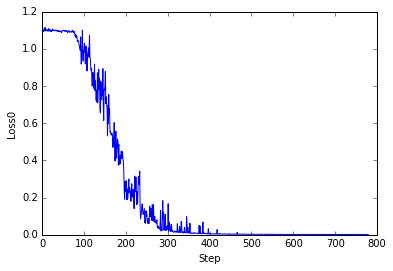

In [13]:
plt.plot(range(len(historic_loss['0'])), historic_loss['0'])
plt.xlabel('Step')
plt.ylabel('Loss0')
#plt.legend('Loss0', ncol=2, loc='upper left');

In [14]:
evaluation = pd.read_csv('roberta_model/eval/similarity_evaluation_dev-sts_results.csv')
evaluation.drop(columns=['steps'])

,epoch,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,0.587317,0.513780,0.590866,0.512060,0.590025,0.511199,0.263039,0.230256
1,0,0.587302,0.513784,0.590856,0.512160,0.590021,0.511141,0.263160,0.230337
2,0,0.587314,0.513738,0.590858,0.512073,0.590027,0.511165,0.263219,0.230406
3,0,0.587294,0.513809,0.590844,0.512117,0.590008,0.511115,0.263231,0.230453
4,0,0.587314,0.513739,0.590855,0.512166,0.590021,0.511154,0.263133,0.230636
...,...,...,...,...,...,...,...,...,...
775,19,0.150136,0.188502,0.170728,0.191592,0.170272,0.189913,0.131947,0.148978
776,19,0.150110,0.188463,0.170709,0.191589,0.170258,0.189749,0.131973,0.148960
777,19,0.150148,0.188724,0.170765,0.191729,0.170314,0.190063,0.131991,0.148901
778,19,0.150118,0.188602,0.170735,0.191878,0.170285,0.189924,0.131960,0.149014


Si se quiere evaluar con el mismo ESXNLI usar este código
```
entailment_samples = []
contradiction_samples = []
neutral_samples = []

dataset = {'entailment': entailment_samples,
           'contradiction': contradiction_samples,
           'neutral': neutral_samples}

for k in dataset:
    subsample = es_only_data[es_only_data.gold_label == k]
    for label, s1, s2 in subsample[['gold_label', 'sentence1', 'sentence2']].values:
        input_example = InputExample(texts=[s1, s2], label=label2int[label])
        dataset[k].append(input_example)

train_examples = []
test_examples = []
for k in dataset:
    train_subsample, test_subsample = train_test_split(dataset[k], test_size=0.2, random_state=42)
    train_examples += train_subsample
    test_examples += test_subsample
    
print('Train examples {}, Test examples {}'.format(len(train_examples), len(test_examples)))
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=64, drop_last=False)
```

